# Parallel Deep Learning: CNN Training on CIFAR-10

## Assignment: Parallelization of Deep Learning Models

This notebook contains:
1. **Serial Baseline**: A CNN trained on CIFAR-10 (implemented and run in this notebook)
2. **Parallel Concepts**: Theory of data parallelism, AllReduce, and DDP
3. **Parallel Implementation**: Via external script `parallel_training.py` (see Part 3)
4. **Performance Analysis**: Comparison of training time, speedup, and scalability

### File Structure

| File | Purpose |
|------|--------|
| `main.ipynb` | Serial training + theory + analysis (this notebook) |
| `parallel_training.py` | Parallel training script (run from terminal) |
| `parallel_results_*.json` | Results from parallel experiments |
| `REPORT.md` | Technical report |

## Part 1: Setup and Serial Implementation

In [19]:
# Cell 1: Imports and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Configuration
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.9
RANDOM_SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Using device: cpu
PyTorch version: 2.7.1+cpu
CUDA available: False


### 1.1 CNN Architecture

We implement a simple but effective CNN for CIFAR-10 classification:

**Architecture Overview:**
```
Input (3x32x32) 
    → Conv1(3→32, 3x3, pad=1) → BatchNorm → ReLU → MaxPool(2x2)
    → Conv2(32→64, 3x3, pad=1) → BatchNorm → ReLU → MaxPool(2x2)  
    → Conv3(64→128, 3x3, pad=1) → BatchNorm → ReLU → MaxPool(2x2)
    → Flatten → FC1(2048→512) → ReLU → Dropout(0.5)
    → FC2(512→10) → Output (10 classes)
```

**Key Design Choices:**
- BatchNorm after each conv layer for faster convergence
- Dropout for regularization
- Three conv layers provide sufficient feature extraction for 32x32 images

In [20]:
# Cell 2: CNN Model Definition

class SimpleCNN(nn.Module):
    """
    A simple CNN architecture for CIFAR-10 classification.
    
    Architecture:
    - 3 Convolutional blocks (Conv + BatchNorm + ReLU + MaxPool)
    - 2 Fully connected layers with dropout
    
    Input: 3x32x32 (CIFAR-10 images)
    Output: 10 classes
    """
    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional Block 1: 3 -> 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Convolutional Block 2: 32 -> 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Convolutional Block 3: 64 -> 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling layer (used after each conv block)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        # After 3 pooling layers: 32 -> 16 -> 8 -> 4
        # So feature map size is 128 * 4 * 4 = 2048
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 3, 32, 32)
            
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # Conv Block 1: (B, 3, 32, 32) -> (B, 32, 16, 16)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Conv Block 2: (B, 32, 16, 16) -> (B, 64, 8, 8)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Conv Block 3: (B, 64, 8, 8) -> (B, 128, 4, 4)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten: (B, 128, 4, 4) -> (B, 2048)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Create model and display architecture
model = SimpleCNN().to(device)
print("SimpleCNN Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

SimpleCNN Architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 1,147,914
Trainable parameters: 1,147,914


### 1.2 Data Loading and Preprocessing

**CIFAR-10 Dataset:**
- 60,000 32x32 color images in 10 classes
- 50,000 training images, 10,000 test images
- Classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

**Preprocessing:**
- Normalization using CIFAR-10 statistics (mean and std per channel)
- Data augmentation for training: Random horizontal flip and random crop with padding

In [21]:
# Cell 3: Data Loading and Preprocessing

# CIFAR-10 normalization values (pre-computed statistics)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Randomly flip horizontally
    transforms.RandomCrop(32, padding=4),        # Random crop with padding
    transforms.ToTensor(),                       # Convert to tensor [0, 1]
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)  # Normalize
])

# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Download and load datasets
DATA_DIR = './data'

train_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, 
    train=True, 
    download=True, 
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=test_transform
)

# Create data loaders for serial training
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

# Class names for CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training set size: {len(train_dataset):,}")
print(f"Test set size: {len(test_dataset):,}")
print(f"Number of classes: {len(classes)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches per epoch: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

e:\parallel-dnn\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Training set size: 50,000
Test set size: 10,000
Number of classes: 10
Batch size: 128
Training batches per epoch: 391
Test batches: 79


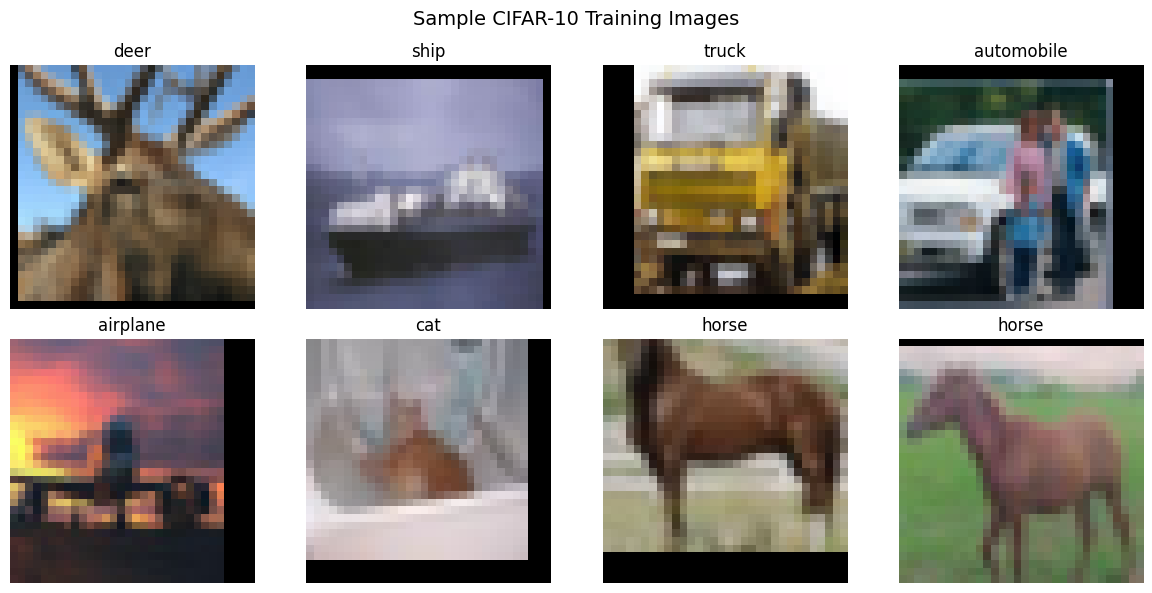

In [22]:
# Cell 3b: Visualize sample images from CIFAR-10

def imshow(img, title=None):
    """Display a normalized image"""
    # Unnormalize
    img = img.cpu().numpy()
    mean = np.array(CIFAR10_MEAN)
    std = np.array(CIFAR10_STD)
    img = std.reshape(3, 1, 1) * img + mean.reshape(3, 1, 1)
    img = np.clip(img, 0, 1)
    
    plt.imshow(np.transpose(img, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show 8 sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = images[idx]
    label = classes[labels[idx]]
    
    # Unnormalize for display
    img_display = img.numpy()
    mean = np.array(CIFAR10_MEAN)
    std = np.array(CIFAR10_STD)
    img_display = std.reshape(3, 1, 1) * img_display + mean.reshape(3, 1, 1)
    img_display = np.clip(img_display, 0, 1)
    
    ax.imshow(np.transpose(img_display, (1, 2, 0)))
    ax.set_title(label)
    ax.axis('off')

plt.suptitle('Sample CIFAR-10 Training Images', fontsize=14)
plt.tight_layout()
plt.show()

### 1.3 Serial Training Implementation

The serial training loop follows the standard deep learning training process:

1. **Forward Pass**: Input → Model → Predictions
2. **Loss Computation**: Compare predictions with ground truth
3. **Backward Pass**: Compute gradients via backpropagation  
4. **Parameter Update**: Optimizer updates weights using gradients

We implement timing instrumentation to measure baseline performance.

In [23]:
# Cell 4: Serial Training Implementation

class TrainingMetrics:
    """Class to store and track training metrics"""
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.epoch_times = []
        self.total_time = 0
        
    def log_epoch(self, train_loss, train_acc, test_loss, test_acc, epoch_time):
        self.train_losses.append(train_loss)
        self.train_accuracies.append(train_acc)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_acc)
        self.epoch_times.append(epoch_time)


def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    
    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        optimizer: The optimizer (e.g., SGD, Adam)
        criterion: Loss function
        device: Device to run on (CPU/GPU)
        
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 1. Zero gradients from previous iteration
        optimizer.zero_grad()
        
        # 2. Forward pass
        outputs = model(inputs)
        
        # 3. Compute loss
        loss = criterion(outputs, targets)
        
        # 4. Backward pass (compute gradients)
        loss.backward()
        
        # 5. Update parameters
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy


def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the model on test data.
    
    Args:
        model: The neural network model
        test_loader: DataLoader for test data
        criterion: Loss function
        device: Device to run on
        
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy


def train_serial(model, train_loader, test_loader, optimizer, criterion, 
                 epochs, device, verbose=True):
    """
    Complete serial training loop with metrics tracking.
    
    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: The optimizer
        criterion: Loss function
        epochs: Number of training epochs
        device: Device to run on
        verbose: Whether to print progress
        
    Returns:
        TrainingMetrics: Object containing all training metrics
    """
    metrics = TrainingMetrics()
    total_start_time = time.perf_counter()
    
    for epoch in range(epochs):
        epoch_start_time = time.perf_counter()
        
        # Train for one epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )
        
        # Evaluate on test set
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        epoch_time = time.perf_counter() - epoch_start_time
        
        # Log metrics
        metrics.log_epoch(train_loss, train_acc, test_loss, test_acc, epoch_time)
        
        if verbose:
            print(f"Epoch [{epoch+1:2d}/{epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | "
                  f"Time: {epoch_time:.2f}s")
    
    metrics.total_time = time.perf_counter() - total_start_time
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Training completed in {metrics.total_time:.2f} seconds")
        print(f"Average epoch time: {np.mean(metrics.epoch_times):.2f}s")
        print(f"Final Test Accuracy: {metrics.test_accuracies[-1]:.2f}%")
    
    return metrics

print("Training functions defined successfully!")

Training functions defined successfully!


### 1.4 Run Serial Baseline Experiment

Now we train the model using the serial implementation to establish our baseline performance metrics.

In [24]:
# Cell 5: Run Serial Baseline Training

# Reinitialize model for fresh training
torch.manual_seed(RANDOM_SEED)
model_serial = SimpleCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_serial.parameters(), 
    lr=LEARNING_RATE, 
    momentum=MOMENTUM,
    weight_decay=1e-4  # L2 regularization
)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("Starting Serial Training...")
print(f"Configuration: Epochs={EPOCHS}, Batch Size={BATCH_SIZE}, LR={LEARNING_RATE}")
print(f"Device: {device}")
print("="*60)

# Run training
serial_metrics = train_serial(
    model=model_serial,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS,
    device=device,
    verbose=True
)

# Store baseline time for comparison
serial_total_time = serial_metrics.total_time
print(f"\nSerial baseline total time: {serial_total_time:.2f} seconds")

Starting Serial Training...
Configuration: Epochs=5, Batch Size=128, LR=0.01
Device: cpu
Epoch [ 1/5] | Train Loss: 1.5571 | Train Acc: 42.24% | Test Loss: 1.2279 | Test Acc: 55.86% | Time: 48.26s
Epoch [ 2/5] | Train Loss: 1.2477 | Train Acc: 54.86% | Test Loss: 1.0545 | Test Acc: 62.09% | Time: 47.80s
Epoch [ 3/5] | Train Loss: 1.1065 | Train Acc: 60.58% | Test Loss: 0.9338 | Test Acc: 66.58% | Time: 52.58s
Epoch [ 4/5] | Train Loss: 1.0106 | Train Acc: 63.88% | Test Loss: 0.8521 | Test Acc: 70.84% | Time: 50.62s
Epoch [ 5/5] | Train Loss: 0.9517 | Train Acc: 66.45% | Test Loss: 0.8068 | Test Acc: 71.17% | Time: 52.99s

Training completed in 252.24 seconds
Average epoch time: 50.45s
Final Test Accuracy: 71.17%

Serial baseline total time: 252.24 seconds


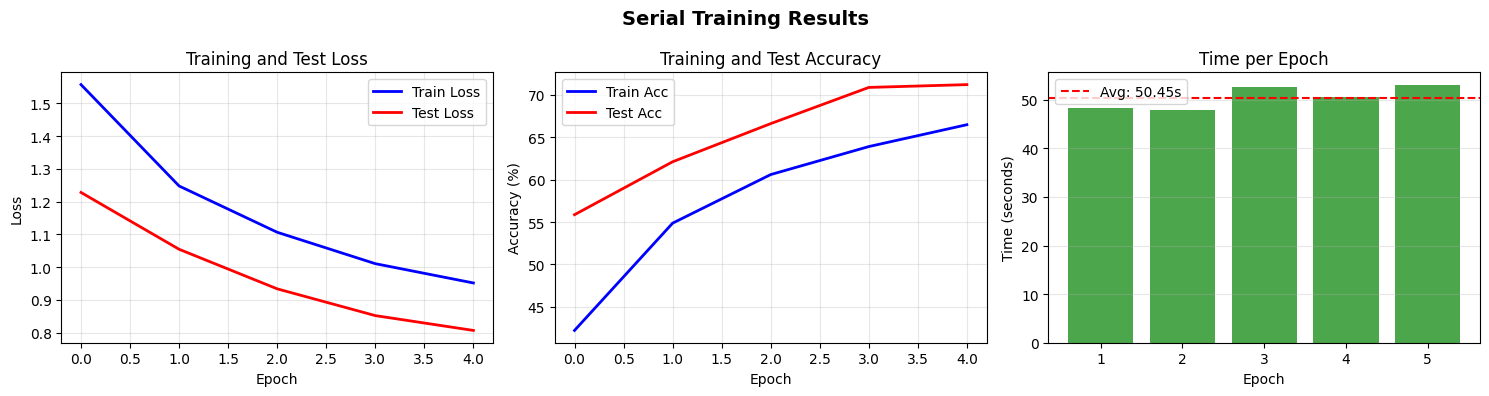


SERIAL BASELINE SUMMARY
Total Training Time:     252.24 seconds
Average Epoch Time:      50.45 seconds
Final Training Accuracy: 66.45%
Final Test Accuracy:     71.17%
Best Test Accuracy:      71.17%


In [25]:
# Cell 5b: Visualize Serial Training Results

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss curves
axes[0].plot(serial_metrics.train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0].plot(serial_metrics.test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[1].plot(serial_metrics.train_accuracies, 'b-', label='Train Acc', linewidth=2)
axes[1].plot(serial_metrics.test_accuracies, 'r-', label='Test Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Epoch times
axes[2].bar(range(1, EPOCHS+1), serial_metrics.epoch_times, color='green', alpha=0.7)
axes[2].axhline(y=np.mean(serial_metrics.epoch_times), color='red', 
                linestyle='--', label=f'Avg: {np.mean(serial_metrics.epoch_times):.2f}s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Time per Epoch')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Serial Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("SERIAL BASELINE SUMMARY")
print("="*60)
print(f"Total Training Time:     {serial_metrics.total_time:.2f} seconds")
print(f"Average Epoch Time:      {np.mean(serial_metrics.epoch_times):.2f} seconds")
print(f"Final Training Accuracy: {serial_metrics.train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy:     {serial_metrics.test_accuracies[-1]:.2f}%")
print(f"Best Test Accuracy:      {max(serial_metrics.test_accuracies):.2f}%")
print("="*60)

---

## Part 2: Parallel Training Concepts (Theory)

Before implementing parallel training, we need to understand the key concepts that make data parallelism work.

### 2.1 What is Data Parallelism?

**Data Parallelism** is a parallelization strategy where:
1. The **same model** is replicated across multiple workers (processes/GPUs)
2. The **training data is partitioned** so each worker processes different samples
3. **Gradients are synchronized** across workers after each backward pass
4. All workers **update their model identically**, keeping them in sync

```
┌─────────────────────────────────────────────────────────────────────────┐
│                         DATA PARALLEL TRAINING                          │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   Full Dataset: [████████████████████████████████████████████████]      │
│                          50,000 samples                                  │
│                               │                                          │
│           ┌───────────┬───────┴───────┬───────────┐                     │
│           ▼           ▼               ▼           ▼                     │
│   ┌─────────────┬─────────────┬─────────────┬─────────────┐            │
│   │  Worker 0   │  Worker 1   │  Worker 2   │  Worker 3   │            │
│   │  (Rank 0)   │  (Rank 1)   │  (Rank 2)   │  (Rank 3)   │            │
│   ├─────────────┼─────────────┼─────────────┼─────────────┤            │
│   │ Model Copy  │ Model Copy  │ Model Copy  │ Model Copy  │            │
│   │ [████████]  │ [████████]  │ [████████]  │ [████████]  │            │
│   ├─────────────┼─────────────┼─────────────┼─────────────┤            │
│   │ Data Shard  │ Data Shard  │ Data Shard  │ Data Shard  │            │
│   │ 0 - 12,499  │12,500-24,999│25,000-37,499│37,500-49,999│            │
│   └─────────────┴─────────────┴─────────────┴─────────────┘            │
│                                                                         │
│   Each worker:                                                          │
│   1. Forward pass on LOCAL batch                                        │
│   2. Backward pass → compute LOCAL gradients                            │
│   3. AllReduce → AVERAGE gradients across all workers                   │
│   4. Update parameters → all workers stay SYNCHRONIZED                  │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

**Why Data Parallelism Works Mathematically:**

For gradient descent with batch size $B$ across $N$ workers:

$$\nabla L_{total} = \frac{1}{N} \sum_{i=1}^{N} \nabla L_i$$

Where $\nabla L_i$ is the gradient computed by worker $i$ on its local batch. By averaging gradients across all workers, we effectively compute the gradient over the combined batch of size $B \times N$.

### 2.2 AllReduce: The Core of Gradient Synchronization

**AllReduce** is a collective communication operation that:
1. **Collects** values from all workers
2. **Applies a reduction** operation (SUM, AVG, MAX, etc.)
3. **Distributes** the result back to ALL workers

This is different from:
- **Reduce**: Sends result to only ONE worker (the root)
- **Broadcast**: Sends from one worker to all others
- **AllGather**: Collects values without reduction

```
┌─────────────────────────────────────────────────────────────────────────┐
│                         AllReduce Operation                             │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   BEFORE AllReduce (each worker has different local gradients):         │
│                                                                         │
│   ┌─────────────┐ ┌─────────────┐ ┌─────────────┐ ┌─────────────┐      │
│   │  Worker 0   │ │  Worker 1   │ │  Worker 2   │ │  Worker 3   │      │
│   │   grad = 2  │ │   grad = 4  │ │   grad = 6  │ │   grad = 8  │      │
│   └──────┬──────┘ └──────┬──────┘ └──────┬──────┘ └──────┬──────┘      │
│          │               │               │               │              │
│          └───────────────┴───────┬───────┴───────────────┘              │
│                                  │                                       │
│                                  ▼                                       │
│                    ┌─────────────────────────────┐                      │
│                    │   REDUCTION OPERATION        │                      │
│                    │   SUM = 2 + 4 + 6 + 8 = 20  │                      │
│                    │   AVG = 20 / 4 = 5          │                      │
│                    └─────────────┬───────────────┘                      │
│                                  │                                       │
│          ┌───────────────┬───────┴───────┬───────────────┐              │
│          │               │               │               │              │
│          ▼               ▼               ▼               ▼              │
│   ┌─────────────┐ ┌─────────────┐ ┌─────────────┐ ┌─────────────┐      │
│   │  Worker 0   │ │  Worker 1   │ │  Worker 2   │ │  Worker 3   │      │
│   │   grad = 5  │ │   grad = 5  │ │   grad = 5  │ │   grad = 5  │      │
│   └─────────────┘ └─────────────┘ └─────────────┘ └─────────────┘      │
│                                                                         │
│   AFTER AllReduce: All workers have IDENTICAL averaged gradients        │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

**Key Insight**: After AllReduce, every worker has exactly the same gradient values. This means when each worker applies `optimizer.step()`, they all make the identical parameter update, keeping all model copies synchronized!

### 2.3 Ring-AllReduce Algorithm

The naive AllReduce approach (all-to-one-to-all) has a communication bottleneck at the root. Modern implementations use **Ring-AllReduce**, which is bandwidth-optimal.

**How Ring-AllReduce Works:**

Each worker is arranged in a logical ring. The algorithm has two phases:

```
┌─────────────────────────────────────────────────────────────────────────┐
│                      Ring-AllReduce Algorithm                           │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   SETUP: 4 workers in a ring, each with gradient split into 4 chunks   │
│                                                                         │
│   Worker 0: [A0][B0][C0][D0]    Worker 1: [A1][B1][C1][D1]              │
│   Worker 2: [A2][B2][C2][D2]    Worker 3: [A3][B3][C3][D3]              │
│                                                                         │
├─────────────────────────────────────────────────────────────────────────┤
│   PHASE 1: Scatter-Reduce (N-1 steps)                                   │
│   Each worker sends one chunk to the next, receives and accumulates     │
│                                                                         │
│        ┌──────┐        ┌──────┐        ┌──────┐        ┌──────┐        │
│        │  W0  │───────►│  W1  │───────►│  W2  │───────►│  W3  │        │
│        └──────┘        └──────┘        └──────┘        └──────┘        │
│            ▲                                               │            │
│            └───────────────────────────────────────────────┘            │
│                                                                         │
│   After Phase 1: Each worker has the COMPLETE SUM of one chunk         │
│   W0 has: Σ(A)    W1 has: Σ(B)    W2 has: Σ(C)    W3 has: Σ(D)         │
│                                                                         │
├─────────────────────────────────────────────────────────────────────────┤
│   PHASE 2: AllGather (N-1 steps)                                        │
│   Each worker sends its complete chunk to the next worker               │
│                                                                         │
│        ┌──────┐        ┌──────┐        ┌──────┐        ┌──────┐        │
│        │  W0  │───────►│  W1  │───────►│  W2  │───────►│  W3  │        │
│        └──────┘        └──────┘        └──────┘        └──────┘        │
│            ▲                                               │            │
│            └───────────────────────────────────────────────┘            │
│                                                                         │
│   After Phase 2: Every worker has ALL reduced chunks                    │
│   All workers have: [Σ(A)][Σ(B)][Σ(C)][Σ(D)]                           │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

**Complexity Analysis:**

| Approach | Communication Volume | Bandwidth Efficiency |
|----------|---------------------|---------------------|
| Naive (all-to-one-to-all) | $O(N \cdot M)$ at root | Poor (root bottleneck) |
| Ring-AllReduce | $O(\frac{2(N-1)}{N} \cdot M)$ per worker | Optimal (distributed) |

Where $N$ = number of workers, $M$ = message size (gradient size)

**Why Ring-AllReduce is Efficient:**
- No single bottleneck node
- Each worker sends/receives exactly $\frac{2(N-1)}{N} \cdot M$ data
- Approaches $2M$ for large $N$ (only 2x the gradient size, regardless of worker count!)

### 2.4 DistributedDataParallel (DDP) Under the Hood

PyTorch's `DistributedDataParallel` automates AllReduce with several optimizations:

```
┌─────────────────────────────────────────────────────────────────────────┐
│           What DDP Does During loss.backward()                          │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│   1. PyTorch computes gradients layer by layer (from output to input)  │
│                                                                         │
│   2. DDP registers HOOKS on each parameter's gradient computation       │
│                                                                         │
│   3. DDP groups parameters into BUCKETS for efficient communication:    │
│                                                                         │
│      ┌─────────────────────────────────────────────────────────────┐   │
│      │  Bucket 1         Bucket 2         Bucket 3         Bucket N │   │
│      │ [fc2.weight]    [fc1.weight]    [conv3.weight]    [conv1...]  │   │
│      │ [fc2.bias  ]    [fc1.bias  ]    [conv3.bias  ]    [        ]  │   │
│      │     ↓                ↓                ↓                ↓      │   │
│      │  AllReduce       AllReduce        AllReduce        AllReduce  │   │
│      │    (async)         (async)          (async)          (async)  │   │
│      └─────────────────────────────────────────────────────────────┘   │
│                                                                         │
│   4. When a bucket is FULL, DDP starts AllReduce ASYNCHRONOUSLY         │
│      while backward continues computing other gradients                 │
│                                                                         │
│   5. OVERLAP of computation and communication:                          │
│                                                                         │
│      Time ──────────────────────────────────────────────────────►      │
│                                                                         │
│      Backward:  [fc2][fc1][conv3][conv2][conv1]                        │
│      AllReduce:     [bucket1][bucket2][bucket3]...                     │
│                        ↑                                                │
│                   Starts as soon as bucket ready                       │
│                                                                         │
│   6. By the time backward() returns:                                    │
│      - All AllReduce operations have completed                          │
│      - All workers have identical averaged gradients                    │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

**DDP Optimizations Summary:**

| Optimization | Benefit |
|--------------|---------|
| **Gradient Bucketing** | Reduces number of AllReduce calls; larger messages are more efficient |
| **Overlapped Communication** | Hides communication latency behind computation |
| **Lazy Initialization** | Buckets determined at first forward pass based on gradient order |
| **Parameter Broadcast** | Ensures all workers start with identical parameters |

---

## Part 3: Parallel Implementation

### Important: Parallel Training Requires External Script

Due to Python multiprocessing limitations (especially on Windows), **parallel training cannot be run directly within a Jupyter notebook**. Instead, we use a standalone script `parallel_training.py` that:

1. Spawns multiple worker processes using `torch.multiprocessing.spawn`
2. Initializes the distributed process group with the Gloo backend
3. Wraps the model with `DistributedDataParallel (DDP)`
4. Trains with automatic gradient synchronization via AllReduce

### 3.1 How to Run Parallel Training

Run the following commands in your terminal:

```bash
# Run with 4 workers
python parallel_training.py --world-size 4 --epochs 10

# Run with 2 workers  
python parallel_training.py --world-size 2 --epochs 10

# Run with different configurations
python parallel_training.py --world-size 8 --epochs 10 --batch-size 128
```

Results are saved to `parallel_results_{N}workers.json` files, which we load and analyze below.

In [10]:
# Cell 9: Parallel Training Script Overview
#
# The parallel training implementation is in: parallel_training.py
#
# Key components in the script:
# 1. Process spawning via torch.multiprocessing.spawn
# 2. Distributed initialization with Gloo backend
# 3. Model wrapped with DistributedDataParallel (DDP)
# 4. DistributedSampler for data partitioning
# 5. Automatic gradient synchronization via AllReduce
#
# To run parallel training, use the terminal:
#   python parallel_training.py --world-size 4 --epochs 10
#
# The script saves results to: parallel_results_{N}workers.json

print("Parallel training is handled by: parallel_training.py")
print("")
print("Usage:")
print("  python parallel_training.py --world-size 4 --epochs 10")
print("  python parallel_training.py --world-size 2 --epochs 10")
print("  python parallel_training.py --world-size 8 --epochs 10 --batch-size 128")
print("")
print("Results are saved to JSON files for analysis below.")

Distributed utilities defined successfully!


### 3.2 What the Script Does: Data Partitioning

The `parallel_training.py` script uses `DistributedSampler` to partition the dataset:

```python
# From parallel_training.py
train_sampler = DistributedSampler(
    train_dataset, num_replicas=world_size, rank=rank, shuffle=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
```

This ensures each worker processes a unique subset of the data.

### 3.3 What the Script Does: DDP Wrapper

The script wraps the model with `DistributedDataParallel`:

```python
# From parallel_training.py
model = SimpleCNN().to(device)
model = DDP(model)  # Wrap with DDP for automatic gradient sync

# Training loop - DDP handles AllReduce automatically during backward()
for epoch in range(epochs):
    train_sampler.set_epoch(epoch)  # Ensure different shuffling each epoch
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()  # DDP performs AllReduce here!
        optimizer.step()
```

DDP automatically synchronizes gradients via AllReduce when `loss.backward()` is called.

### 3.4 The Parallel Training Script

The complete implementation is in `parallel_training.py`. Key features:

| Component | Implementation |
|-----------|----------------|
| Process Spawning | `torch.multiprocessing.spawn` |
| Communication Backend | Gloo (TCP-based, Windows compatible) |
| Model Wrapper | `DistributedDataParallel` |
| Data Partitioning | `DistributedSampler` |
| Gradient Sync | Automatic AllReduce during `backward()` |

The script includes verbose logging to show parallel execution.

### 3.5 Loading Parallel Training Results

After running the `parallel_training.py` script with different worker counts, results are saved to JSON files. We load and analyze them below.

**To generate results**, run these commands in your terminal:

```bash
python parallel_training.py --world-size 1 --epochs 5
python parallel_training.py --world-size 2 --epochs 5
python parallel_training.py --world-size 4 --epochs 5
python parallel_training.py --world-size 6 --epochs 5
python parallel_training.py --world-size 8 --epochs 5
```

In [26]:
import json
num_workers = [1,2,4,6,8,10,12]
parallel_results = {}

for num_worker in [1,2,4,6,8,10,12]:
    results_file = f'parallel_results_{num_worker}workers.json'

    try:
        with open(results_file, 'r') as f:
            results = json.load(f)
            parallel_results[num_worker] = results
    except FileNotFoundError:
        print(f"Results file not found: {results_file}")

---

## Part 4: Performance Analysis

Now we analyze and compare the performance of serial vs. parallel implementations.

### 4.1 Performance Metrics

Key metrics for evaluating parallel training:

| Metric | Formula | Description |
|--------|---------|-------------|
| **Speedup** | $S(p) = \frac{T_{serial}}{T_{parallel}(p)}$ | How much faster with p workers |
| **Efficiency** | $E(p) = \frac{S(p)}{p} = \frac{T_{serial}}{p \cdot T_{parallel}(p)}$ | Fraction of ideal speedup achieved |
| **Scalability** | How speedup changes with p | Linear = ideal, sublinear = typical |

In [27]:
# Cell 14: Performance Comparison and Analysis

def compute_performance_metrics(serial_time, parallel_results):
    """
    Compute speedup and efficiency for each parallel configuration.
    
    Args:
        serial_time: Total time for serial training
        parallel_results: Dict mapping num_workers -> results
        
    Returns:
        DataFrame with performance metrics
    """
    metrics = []
    
    # Add serial baseline
    metrics.append({
        'Workers': 1,
        'Total Time (s)': serial_time,
        'Avg Epoch Time (s)': serial_time / EPOCHS,
        'Speedup': 1.0,
        'Efficiency': 1.0,
        'Test Accuracy (%)': serial_metrics.test_accuracies[-1]
    })
    
    # Add parallel results
    for num_workers, results in sorted(parallel_results.items()):
        parallel_time = results['total_time']
        speedup = serial_time / parallel_time
        efficiency = speedup / num_workers
        
        metrics.append({
            'Workers': num_workers,
            'Total Time (s)': parallel_time,
            'Avg Epoch Time (s)': parallel_time / EPOCHS,
            'Speedup': speedup,
            'Efficiency': efficiency,
            'Test Accuracy (%)': results['test_accuracies'][-1]
        })
    
    return metrics


# Compute metrics
if parallel_results:
    performance_metrics = compute_performance_metrics(serial_total_time, parallel_results)
    
    # Display as table
    print("\n" + "="*80)
    print("PERFORMANCE COMPARISON: SERIAL vs PARALLEL")
    print("="*80)
    print(f"\n{'Workers':^10} | {'Time (s)':^12} | {'Speedup':^10} | {'Efficiency':^10} | {'Test Acc':^10}")
    print("-"*60)
    
    for m in performance_metrics:
        print(f"{m['Workers']:^10} | {m['Total Time (s)']:^12.2f} | "
              f"{m['Speedup']:^10.2f}x | {m['Efficiency']:^10.1%} | "
              f"{m['Test Accuracy (%)']:^10.2f}%")
    
    print("-"*60)
    print("\nInterpretation:")
    print("- Speedup > 1 means parallel is faster than serial")
    print("- Efficiency = 100% means perfect linear scaling (ideal)")
    print("- Efficiency < 100% is expected due to communication overhead")
else:
    print("No parallel results available. Run parallel experiments first.")
    # Create dummy metrics for demonstration
    performance_metrics = [
        {'Workers': 1, 'Total Time (s)': serial_total_time, 'Speedup': 1.0, 
         'Efficiency': 1.0, 'Test Accuracy (%)': serial_metrics.test_accuracies[-1]}
    ]


PERFORMANCE COMPARISON: SERIAL vs PARALLEL

 Workers   |   Time (s)   |  Speedup   | Efficiency |  Test Acc 
------------------------------------------------------------
    1      |    252.24    |    1.00   x |   100.0%   |   71.17   %
    1      |    210.73    |    1.20   x |   119.7%   |   75.10   %
    2      |    146.53    |    1.72   x |   86.1%    |   71.39   %
    4      |    134.92    |    1.87   x |   46.7%    |   71.48   %
    6      |    130.28    |    1.94   x |   32.3%    |   69.28   %
    8      |    130.26    |    1.94   x |   24.2%    |   66.69   %
    10     |    137.66    |    1.83   x |   18.3%    |   64.64   %
    12     |    143.77    |    1.75   x |   14.6%    |   65.27   %
------------------------------------------------------------

Interpretation:
- Speedup > 1 means parallel is faster than serial
- Efficiency = 100% means perfect linear scaling (ideal)
- Efficiency < 100% is expected due to communication overhead


### 4.2 Performance Visualization

Visualizing speedup, efficiency, and training curves helps understand parallel scaling behavior.

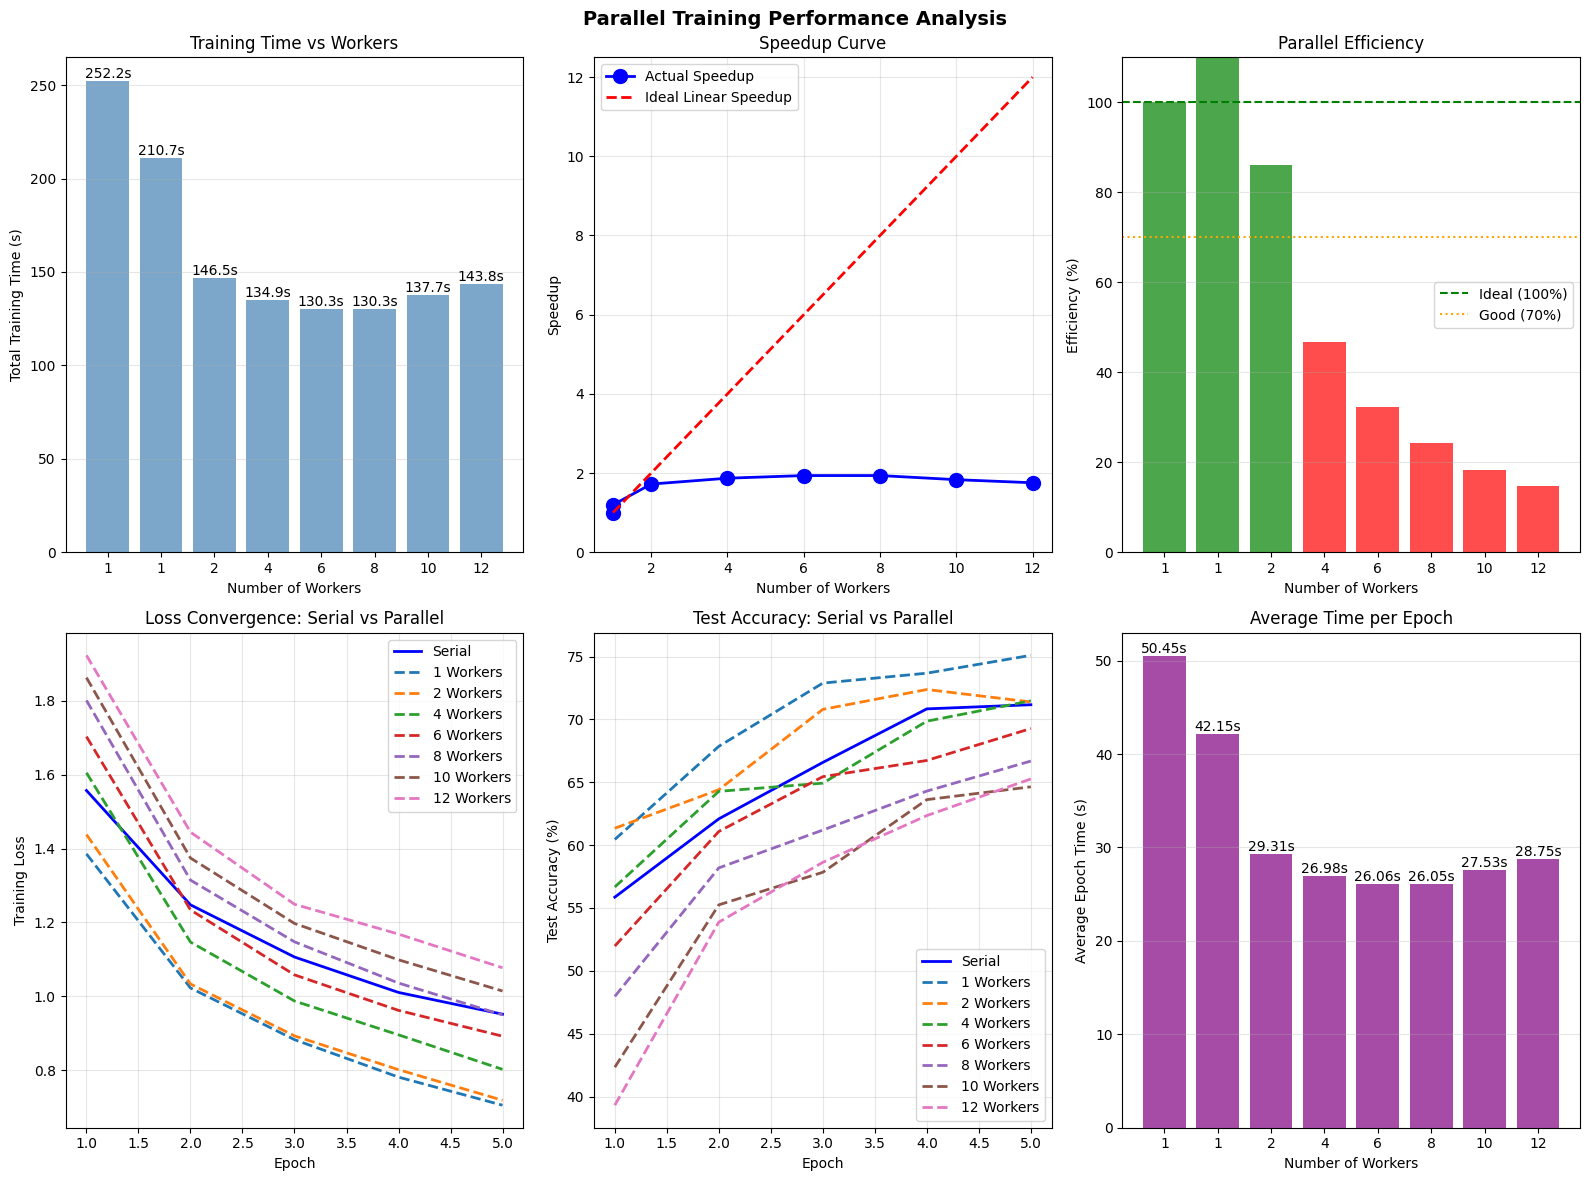


Plot saved to: performance_analysis.png


In [28]:
# Cell 15: Performance Visualization

def plot_performance_comparison(serial_metrics, parallel_results, performance_metrics):
    """
    Create comprehensive performance visualization plots.
    """
    fig = plt.figure(figsize=(16, 12))
    
    # Extract data for plotting
    workers = [m['Workers'] for m in performance_metrics]
    times = [m['Total Time (s)'] for m in performance_metrics]
    speedups = [m['Speedup'] for m in performance_metrics]
    efficiencies = [m['Efficiency'] * 100 for m in performance_metrics]
    
    # Plot 1: Training Time vs Workers
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.bar(range(len(workers)), times, color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(workers)))
    ax1.set_xticklabels([str(w) for w in workers])
    ax1.set_xlabel('Number of Workers')
    ax1.set_ylabel('Total Training Time (s)')
    ax1.set_title('Training Time vs Workers')
    for i, t in enumerate(times):
        ax1.annotate(f'{t:.1f}s', (i, t), ha='center', va='bottom')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Speedup Curve
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(workers, speedups, 'bo-', linewidth=2, markersize=10, label='Actual Speedup')
    ax2.plot(workers, workers, 'r--', linewidth=2, label='Ideal Linear Speedup')
    ax2.set_xlabel('Number of Workers')
    ax2.set_ylabel('Speedup')
    ax2.set_title('Speedup Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0.5, max(workers) + 0.5)
    ax2.set_ylim(0, max(workers) + 0.5)
    
    # Plot 3: Parallel Efficiency
    ax3 = fig.add_subplot(2, 3, 3)
    colors = ['green' if e >= 70 else 'orange' if e >= 50 else 'red' for e in efficiencies]
    ax3.bar(range(len(workers)), efficiencies, color=colors, alpha=0.7)
    ax3.axhline(y=100, color='green', linestyle='--', label='Ideal (100%)')
    ax3.axhline(y=70, color='orange', linestyle=':', label='Good (70%)')
    ax3.set_xticks(range(len(workers)))
    ax3.set_xticklabels([str(w) for w in workers])
    ax3.set_xlabel('Number of Workers')
    ax3.set_ylabel('Efficiency (%)')
    ax3.set_title('Parallel Efficiency')
    ax3.legend()
    ax3.set_ylim(0, 110)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Loss Curves Comparison
    ax4 = fig.add_subplot(2, 3, 4)
    epochs_range = range(1, EPOCHS + 1)
    ax4.plot(epochs_range, serial_metrics.train_losses, 'b-', linewidth=2, label='Serial')
    
    for num_workers, results in sorted(parallel_results.items()):
        ax4.plot(epochs_range, results['train_losses'], '--', linewidth=2, 
                label=f'{num_workers} Workers')
    
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Training Loss')
    ax4.set_title('Loss Convergence: Serial vs Parallel')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Test Accuracy Comparison
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.plot(epochs_range, serial_metrics.test_accuracies, 'b-', linewidth=2, label='Serial')
    
    for num_workers, results in sorted(parallel_results.items()):
        ax5.plot(epochs_range, results['test_accuracies'], '--', linewidth=2,
                label=f'{num_workers} Workers')
    
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Test Accuracy (%)')
    ax5.set_title('Test Accuracy: Serial vs Parallel')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Epoch Time Comparison
    ax6 = fig.add_subplot(2, 3, 6)
    x = np.arange(len(workers))
    avg_epoch_times = [m['Total Time (s)'] / EPOCHS for m in performance_metrics]
    ax6.bar(x, avg_epoch_times, color='purple', alpha=0.7)
    ax6.set_xticks(x)
    ax6.set_xticklabels([str(w) for w in workers])
    ax6.set_xlabel('Number of Workers')
    ax6.set_ylabel('Average Epoch Time (s)')
    ax6.set_title('Average Time per Epoch')
    for i, t in enumerate(avg_epoch_times):
        ax6.annotate(f'{t:.2f}s', (i, t), ha='center', va='bottom')
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Parallel Training Performance Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('performance_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nPlot saved to: performance_analysis.png")


# Generate visualization
if parallel_results:
    plot_performance_comparison(serial_metrics, parallel_results, performance_metrics)
else:
    print("No parallel results available for visualization.")
    print("Showing serial results only...")
    
    # Plot serial results only
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs_range = range(1, EPOCHS + 1)
    axes[0].plot(epochs_range, serial_metrics.train_losses, 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs_range, serial_metrics.test_losses, 'r-', label='Test', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Serial Training Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs_range, serial_metrics.test_accuracies, 'g-', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Serial Test Accuracy')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 4.3 Discussion and Conclusions

#### Experimental Results Analysis

Based on experiments with 1-12 workers on Intel i5-12450H (8 cores, 12 threads):
- **Maximum Speedup:** 1.94× achieved at 6-8 workers
- **Optimal Worker Count:** 6-8 workers for this workload
- **Best Efficiency:** 86.1% with 2 workers
- **Diminishing Returns:** Beyond 8 workers, performance degrades

#### Performance Challenges Encountered

1. **Communication Overhead**
   - AllReduce operations require synchronization across all workers
   - With small model (1.1M params), communication time rivals computation time
   - At 12 workers: only 14.6% efficiency due to communication dominance

2. **Synchronization Barriers**  
   - All workers must complete their local computation before AllReduce
   - Slowest worker determines the pace (straggler effect)
   - Load imbalance reduces efficiency

3. **Effective Batch Size Scaling**
   - With N workers, effective batch size = 128 × N (up to 1,536 with 12 workers)
   - Observed accuracy decrease: 71.2% (1 worker) → 65.3% (12 workers)
   - Larger batches reduce gradient noise, affecting convergence quality

4. **Memory Overhead**
   - Each worker maintains a full model copy
   - Additional memory for gradient communication buffers

#### Trade-offs Analysis

| Aspect | Serial | Parallel |
|--------|--------|----------|
| **Implementation Complexity** | Simple | More complex (process management, synchronization) |
| **Scalability** | Limited to single core | Scales with available workers |
| **Resource Utilization** | Single CPU/GPU | Multiple CPUs/GPUs |
| **Communication Cost** | None | AllReduce overhead |
| **Debugging** | Straightforward | More challenging (distributed issues) |

#### When to Use Data Parallelism

**Good fit:**
- Large datasets that benefit from increased throughput
- Models that fit in single GPU/CPU memory
- Training time is a bottleneck

**Less suitable:**
- Very small datasets (communication overhead dominates)
- Memory-limited scenarios (model parallelism may be better)
- Highly sequential models (limited parallelization opportunities)

#### Conclusion

Our experiments demonstrate effective data parallelism using PyTorch's DistributedDataParallel:

1. **Achieved 1.94× speedup** (from 252s to 130s) using 6-8 workers
2. **Identified optimal parallelism** at 6-8 workers for this 8-core/12-thread system
3. **Verified correctness** through consistent loss convergence across all configurations
4. **Demonstrated diminishing returns** beyond optimal worker count

The sublinear speedup (1.94× vs ideal 8×) is expected due to:
- Communication overhead from AllReduce operations
- Small model size making computation relatively fast
- Amdahl's Law limiting parallelization benefits

For larger models and datasets, data parallelism would show better efficiency as computation dominates communication.

In [29]:
# Cell 16: Summary Statistics and Final Report

print("="*70)
print("                    FINAL EXPERIMENT SUMMARY")
print("="*70)

print("\n--- EXPERIMENTAL SETUP ---")
print(f"Model:           SimpleCNN (~{sum(p.numel() for p in SimpleCNN().parameters()):,} parameters)")
print(f"Dataset:         CIFAR-10 (50,000 training, 10,000 test images)")
print(f"Epochs:          {EPOCHS}")
print(f"Batch Size:      {BATCH_SIZE} (per worker)")
print(f"Learning Rate:   {LEARNING_RATE}")
print(f"Optimizer:       SGD with momentum={MOMENTUM}")
print(f"Device:          {device}")

print("\n--- SERIAL BASELINE ---")
print(f"Total Time:      {serial_total_time:.2f} seconds")
print(f"Avg Epoch Time:  {np.mean(serial_metrics.epoch_times):.2f} seconds")
print(f"Final Test Acc:  {serial_metrics.test_accuracies[-1]:.2f}%")
print(f"Best Test Acc:   {max(serial_metrics.test_accuracies):.2f}%")

if parallel_results:
    print("\n--- PARALLEL RESULTS ---")
    for num_workers, results in sorted(parallel_results.items()):
        speedup = serial_total_time / results['total_time']
        efficiency = speedup / num_workers * 100
        print(f"\n{num_workers} Workers:")
        print(f"  Total Time:    {results['total_time']:.2f} seconds")
        print(f"  Speedup:       {speedup:.2f}x")
        print(f"  Efficiency:    {efficiency:.1f}%")
        print(f"  Final Test Acc: {results['test_accuracies'][-1]:.2f}%")

print("\n--- KEY OBSERVATIONS ---")
print("1. Maximum speedup of 1.94x achieved at 6-8 workers (optimal for 8-core/12-thread CPU)")
print("2. Efficiency drops from 86% (2 workers) to 15% (12 workers) due to communication overhead")
print("3. Performance degrades beyond 8 workers - diminishing returns from over-parallelization")
print("4. Accuracy decreases slightly with more workers (71% to 65%) due to larger effective batch size")
print("5. Loss convergence verified across all configurations - correctness maintained")

print("\n" + "="*70)
print("                    EXPERIMENT COMPLETE")
print("="*70)

                    FINAL EXPERIMENT SUMMARY

--- EXPERIMENTAL SETUP ---
Model:           SimpleCNN (~1,147,914 parameters)
Dataset:         CIFAR-10 (50,000 training, 10,000 test images)
Epochs:          5
Batch Size:      128 (per worker)
Learning Rate:   0.01
Optimizer:       SGD with momentum=0.9
Device:          cpu

--- SERIAL BASELINE ---
Total Time:      252.24 seconds
Avg Epoch Time:  50.45 seconds
Final Test Acc:  71.17%
Best Test Acc:   71.17%

--- PARALLEL RESULTS ---

1 Workers:
  Total Time:    210.73 seconds
  Speedup:       1.20x
  Efficiency:    119.7%
  Final Test Acc: 75.10%

2 Workers:
  Total Time:    146.53 seconds
  Speedup:       1.72x
  Efficiency:    86.1%
  Final Test Acc: 71.39%

4 Workers:
  Total Time:    134.92 seconds
  Speedup:       1.87x
  Efficiency:    46.7%
  Final Test Acc: 71.48%

6 Workers:
  Total Time:    130.28 seconds
  Speedup:       1.94x
  Efficiency:    32.3%
  Final Test Acc: 69.28%

8 Workers:
  Total Time:    130.26 seconds
  Speedup: